In [289]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

### Data Collection

In [290]:
import requests

# URLs of the files
train_data_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module5/exercise/module5_exercise_train.csv'
test_data_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module5/exercise/module5_exercise_test.csv'

# Function to download a file
def download_file(url, file_name):
    response = requests.get(url)
    response.raise_for_status()  # Ensure we notice bad responses
    with open(file_name, 'wb') as file:
        file.write(response.content)
    print(f'Downloaded {file_name} from {url}')

# Downloading the files
download_file(train_data_url, 'module5_exercise_train.csv')
download_file(test_data_url, 'module5_exercise_test.csv')

Downloaded module5_exercise_train.csv from https://www.raphaelcousin.com/modules/data-science-practice/module5/exercise/module5_exercise_train.csv
Downloaded module5_exercise_test.csv from https://www.raphaelcousin.com/modules/data-science-practice/module5/exercise/module5_exercise_test.csv


In [291]:
df_train =  pd.read_csv("module5_exercise_train.csv", sep=",")
df_test =  pd.read_csv("module5_exercise_test.csv", sep=",")

### Data analysis

In [292]:
#### Make a complete analysis on data preprocessing
# Inconsistencies
# Duplicates (data.duplicated().sum())
# Missing values (data.isnull().sum())
# Categorical
# Outliers
# Feature Engineering
# Feature Selection and/or Dimensionality Reduction

In [293]:
data = pd.concat([df_train, df_test], axis=0)

In [294]:
df_train.shape

(1909, 16)

In [295]:
# One less column : electricity_demand
df_test.shape

(365, 15)

In [296]:
def plot_feature_over_time(df, feature, date_id_start, date_id_end):
    df_filtered = df[(df['date'] >= date_id_start) & (df['date'] <= date_id_end)]
    
    if feature not in df_filtered.columns:
        print(f"Feature '{feature}' not found in the DataFrame.")
        return
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(df_filtered['date'], df_filtered[feature], label=feature, linestyle='-')
    plt.xlabel('Date')
    plt.ylabel(feature)
    plt.title(f'{feature} from {date_id_start} to {date_id_end}')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



##### Exploring Inconsistencies

##### Mixed Type Columns

In [297]:
for column in data.columns:
    print(column, data[column].apply(type).unique())

print("\nWeather Condition Values\n")
print(data["weather_condition"].unique())

print("\nWind Speed Non str Values\n")
print(data["wind_speed"][data["wind_speed"].apply(type) == float].unique())

date [<class 'str'>]
weather_condition [<class 'str'> <class 'float'>]
humidity [<class 'float'>]
wind_speed [<class 'str'> <class 'float'>]
oil_brent_price_indicator [<class 'str'>]
temperature_station1 [<class 'float'>]
temperature_station2 [<class 'float'>]
temperature_station3 [<class 'float'>]
temperature_station4 [<class 'float'>]
temperature_station5 [<class 'float'>]
temperature_station6 [<class 'float'>]
temperature_station7 [<class 'float'>]
temperature_station8 [<class 'float'>]
temperature_station9 [<class 'float'>]
temperature_station10 [<class 'float'>]
electricity_demand [<class 'float'>]

Weather Condition Values

['Cloudy' 'Sunny' 'Rainy' 'Snowy' nan]

Wind Speed Non str Values

[nan]


- `weather_condition` must be cast into 4 0-1 columns for `['Cloudy' 'Sunny' 'Rainy' 'Snowy' nan]`
- `wind_speed` missing values must be handled, must be cast to float

##### Missing Values

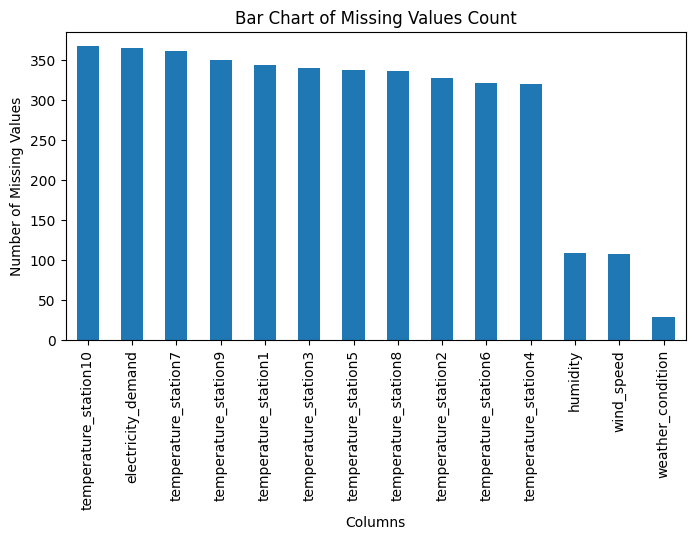

Percentage of missing values per column:
date                          0.00
weather_condition             1.23
humidity                      4.79
wind_speed                    4.71
oil_brent_price_indicator     0.00
temperature_station1         15.13
temperature_station2         14.42
temperature_station3         14.95
temperature_station4         14.07
temperature_station5         14.82
temperature_station6         14.12
temperature_station7         15.88
temperature_station8         14.78
temperature_station9         15.39
temperature_station10        16.14
electricity_demand           16.05
dtype: float64


In [298]:

missing_counts = data.isnull().sum().sort_values(ascending=False)
missing_counts = missing_counts[missing_counts > 0]
plt.figure(figsize=(8, 4))
missing_counts.plot(kind='bar')
plt.title('Bar Chart of Missing Values Count')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.show()

print("Percentage of missing values per column:")
print((data.isnull().sum() / len(data) * 100).round(2))

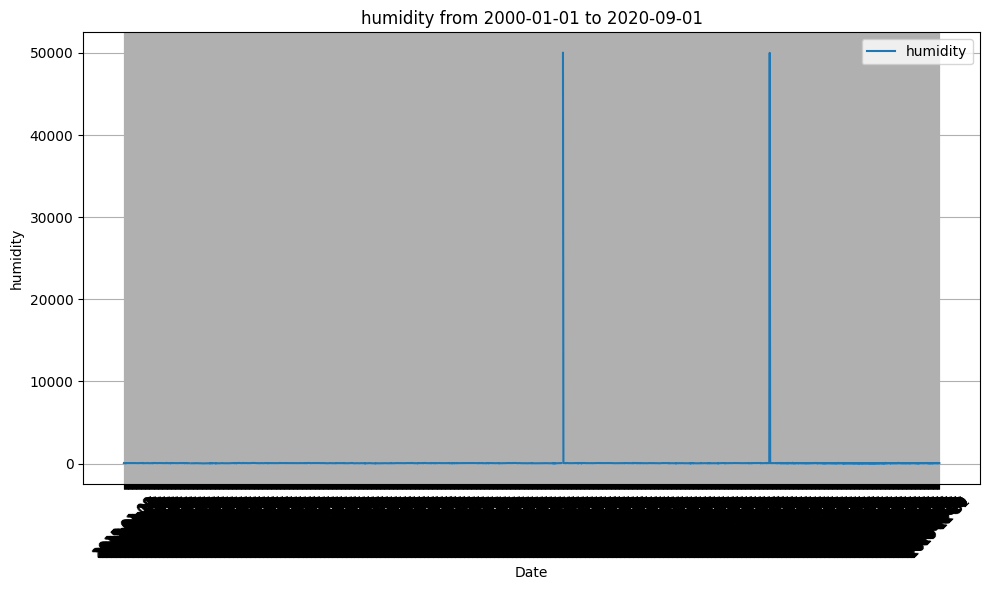

In [299]:
plot_feature_over_time(data, 'humidity', '2000-01-01', '2020-09-01')

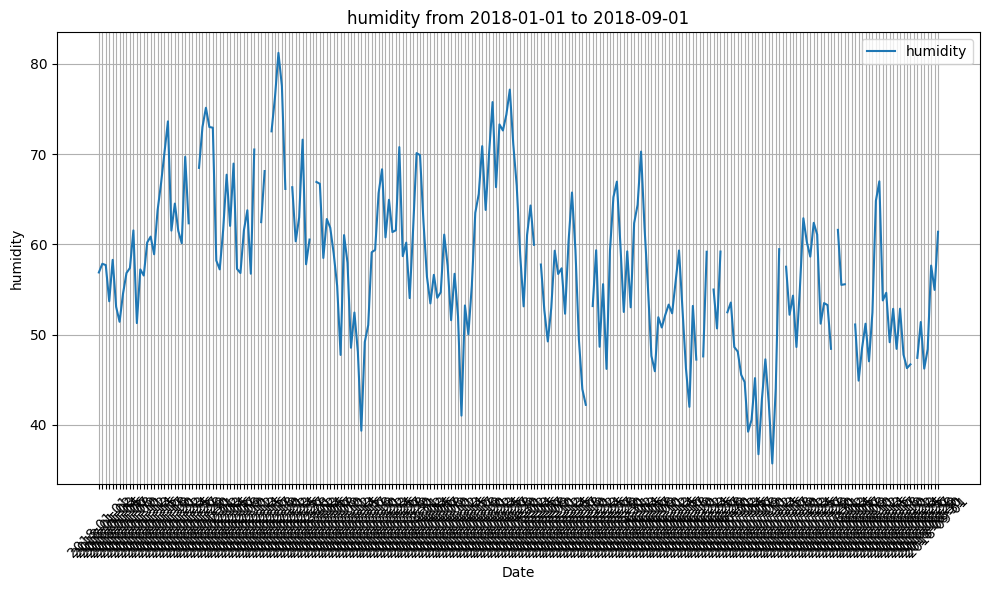

In [300]:
plot_feature_over_time(data, 'humidity', '2018-01-01', '2018-09-01')

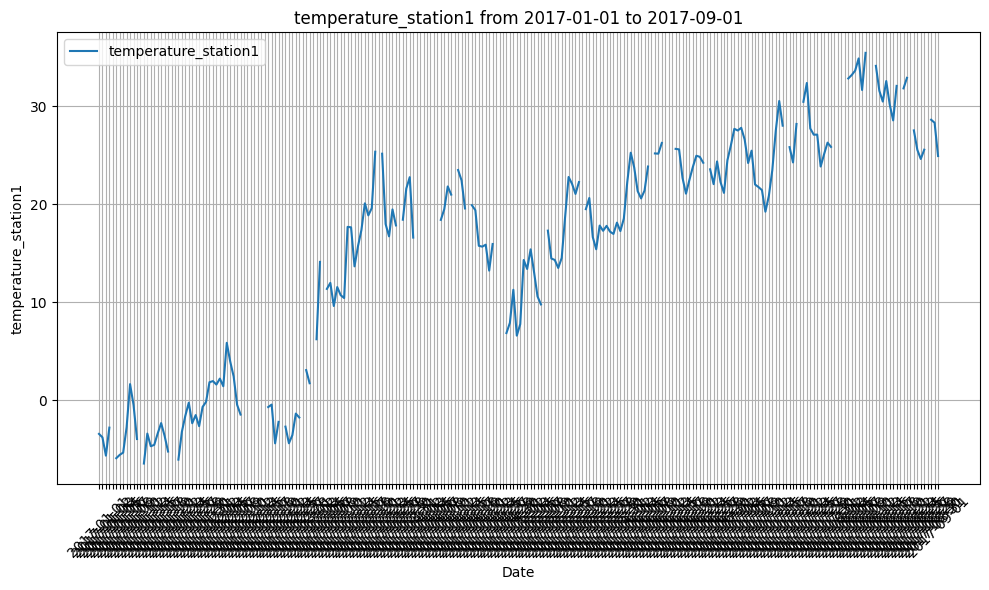

In [301]:
plot_feature_over_time(data, 'temperature_station1', '2017-01-01', '2017-09-01')

- `temperature_station` missing values can be handled with a 3-nearest average
- `weather_condition` should not be too much of a problem if we split in into three 0-1 columns anyway
- `humidity` by linear interpolation, aberant values must be trimmed beforehand
- `wind_speed` must be cast

In [302]:
data

,date,weather_condition,humidity,wind_speed,oil_brent_price_indicator,temperature_station1,temperature_station2,temperature_station3,temperature_station4,temperature_station5,temperature_station6,temperature_station7,temperature_station8,temperature_station9,temperature_station10,electricity_demand
0,2015-01-08,Cloudy,69.304377,27.74 km/h,Moderate,0.369411,NaN,0.159977,0.118224,-0.444455,0.313675,0.106192,0.369430,1.279470,-0.384661,273.511353
1,2015-01-09,Sunny,55.955975,21.78 km/h,Moderate,2.009903,NaN,1.617242,NaN,2.160063,2.515627,1.867474,1.953165,1.878233,1.582365,258.827085
2,2015-01-10,Rainy,62.701614,6.83 m/s,Moderate,-2.603544,-2.422001,-3.685819,-2.392354,-1.936704,-2.950332,-3.074828,-2.698650,-2.354860,-2.770883,302.535033
3,2015-01-11,Snowy,60.375001,5.79 m/s,Moderate,-3.789836,-3.974054,-3.217545,-4.397143,-3.375188,-3.650454,-5.004991,-3.233724,-4.227899,NaN,296.270989
4,2015-01-12,Snowy,NaN,25.14 km/h,High,-2.405522,-2.161129,-2.880773,-2.587199,NaN,NaN,NaN,NaN,-2.790422,-2.033098,323.498090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2019-12-27,Snowy,71.521673,22.78 km/h,Moderate,-1.674798,-2.338987,-1.829170,-0.881428,-0.571347,-2.231680,-1.962735,-1.602805,-1.264779,-1.705180,NaN
361,2019-12-28,Sunny,67.220123,18.33 km/h,High,3.209205,2.508606,2.195577,NaN,NaN,3.236547,3.181473,3.094390,NaN,3.475638,NaN
362,2019-12-29,Rainy,68.085227,7.24 m/s,Moderate,3.688132,3.919479,NaN,4.071717,4.365347,3.580358,3.404292,4.173461,3.755625,4.070333,NaN
363,2019-12-30,Cloudy,65.877214,7.67 m/s,Moderate,NaN,0.700484,NaN,-0.407440,-0.580917,-0.444730,0.034229,0.021199,-0.864657,NaN,NaN


- `humidity` missing values : interpolation
- `wind_speed` unify units and cast to float
- `oil_bent_price_indicator` to ordered category
- `temparature_station*` interpolate missing values ?
- `date` must be split to reflect seasonal changes

In [303]:
data['wind_speed']

0      27.74 km/h
1      21.78 km/h
2        6.83 m/s
3        5.79 m/s
4      25.14 km/h
          ...    
360    22.78 km/h
361    18.33 km/h
362      7.24 m/s
363      7.67 m/s
364    30.99 km/h
Name: wind_speed, Length: 2274, dtype: object

- `wind_speed` unify units and cast to float

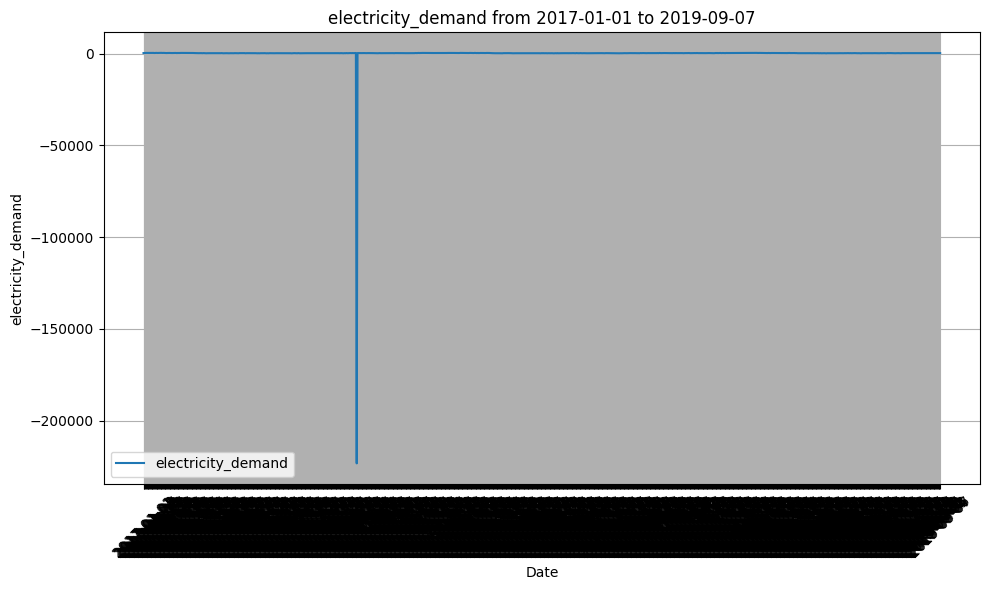

In [304]:
plot_feature_over_time(data, 'electricity_demand', '2017-01-01', '2019-09-07')

- `electricity_demand` : trim (far) outliers, interpolate missing or trimmed values 

**TODO** : Compare `weather_condition` with `humidity` ?

#### Summary

- `date` must be split to reflect seasonal changes
- `weather_condition` must be cast into 4 0-1 columns for `['Cloudy' 'Sunny' 'Rainy' 'Snowy' nan]`, missing values should then not be a major problem
- `wind_speed` missing values must be handled, must be cast to float, units unified
- `electricity_demand` : trim (far) outliers, interpolate missing or trimmed values 
- `humidity` by linear interpolation, aberant values must be trimmed beforehand
- `oil_brent_price_indicator` to ordered category `['Moderate', 'High', 'Low', 'Very Low', 'Very High']`
- `temperature_station` missing values can be handled with a 3-nearest average

In [305]:
data["oil_brent_price_indicator"].unique()

array(['Moderate', 'High', 'Low', 'Very Low', 'Very High'], dtype=object)

### Data Preprocessing Evaluation Strategy

In [306]:
from typing import (
    Optional
)

import re
from scipy import stats
import datetime

# 1. Handle Inconsistencies


def _handle_inconsistencies(data: pd.DataFrame) -> pd.DataFrame:
    """Parse and convert wind_speed."""
    data = data.copy()

    wind_speed_regex = r"^\s*(\d+\.\d+)\s*(km\/h|m\/s)\s*$"

    def parse_wind_speed(wind_speed: str | float) -> float:
        if not isinstance(wind_speed, str):
            return np.nan

        result = re.search(wind_speed_regex, wind_speed)

        if not result:
            return np.nan

        value, unit = result.groups()

        try:
            value = float(value)
        except Exception:
            return np.nan

        match unit:
            case "km/h":
                return value / 3
            case "m/s":
                return value
            case _:
                raise Exception("Bad regex stupid")

    data["wind_speed"] = data["wind_speed"].apply(parse_wind_speed)
    data["date"] = pd.to_datetime(data["date"])

    return data


def handle_inconsistencies(X_train: pd.DataFrame, y_train: pd.DataFrame, X_val: pd.DataFrame | None = None):
    if X_val is not None:
        return _handle_inconsistencies(X_train), y_train, _handle_inconsistencies(X_val)
    else:
        return _handle_inconsistencies(X_train), y_train


# 2. Handling Duplicates
def handle_duplicates(X_train, y_train, X_val=None):
    if X_val is not None:
        return X_train.copy(), y_train, X_val.copy()
    else:
        X_train_no_duplicates = X_train.copy()
        y_train_no_duplicates = y_train.loc[X_train_no_duplicates.index]
        return X_train_no_duplicates, y_train_no_duplicates


def _handle_missing_values(data: pd.DataFrame) -> pd.DataFrame:
    """Interpolate all numeric columns."""
    data = data.copy()
    for column in data.select_dtypes(include="number").columns.tolist():
        data[column] = data[column].interpolate(limit_direction="both")

    return data

# 3. Handling Missing Values


def handle_missing_values(X_train, y_train, X_val=None):
    # Linear interpolation should do it
    # weather condition is not handled, we'll do it later
    if X_val is not None:
        return _handle_missing_values(X_train), _handle_missing_values(X_val)
    else:
        return _handle_missing_values(X_train)

# 4. Handling Categorical Values


def _handle_categorical(data: pd.DataFrame) -> pd.DataFrame:
    """Make weather_condition into 4 boolean columns then drop it. Cast oil_brent_price_indicator to ordered categories."""
    data = data.copy()

    data["oil_brent_price_indicator"] = data["oil_brent_price_indicator"].map({
        "Very Low": 1,
        "Low": 2,
        "Moderate": 3,
        "High": 4,
        "Very High": 5
    })

    data["sunny"] = (data["weather_condition"] == "Sunny").astype(int)
    data["cloudy"] = (data["weather_condition"] == "Cloudy").astype(int)
    data["rainy"] = (data["weather_condition"] == "Rainy").astype(int)
    data["snowy"] = (data["weather_condition"] == "Snowy").astype(int)
    data = data.drop("weather_condition", axis=1)

    return data


def handle_categorical(X_train, y_train, X_val=None):

    if X_val is not None:
        return _handle_categorical(X_train), _handle_categorical(X_val)
    else:
        return _handle_categorical(X_train)

# 5. Handling Outliers


def _handle_outliers(data: pd.DataFrame | pd.Series) -> pd.DataFrame | pd.Series:
    """Replace numeric values 5 sigmas from their mean."""
    data = data.copy()

    if isinstance(data, pd.Series):
        z_scores = np.abs(stats.zscore(data))
        data[z_scores > 5] = data.median()
    else:
        for column in data.select_dtypes(include="number").columns.tolist():
            z_scores = np.abs(stats.zscore(data[column]))
            data.loc[z_scores > 5, column] = data[column].median()

    return data


def handle_outliers(X_train, y_train, X_val=None):

    if X_val is not None:
        return _handle_outliers(X_train), _handle_outliers(y_train), _handle_outliers(X_val)
    else:
        return _handle_outliers(X_train), _handle_outliers(y_train)

# 6. Feature Engineering


def _feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    """Encode year's day into a rotating representation. Drop various temperature stations but add their average."""
    data = data.copy()

    data["day_sin"] = np.sin(
        2 * np.pi * data["date"].apply(lambda date: date.timetuple().tm_yday) / 366)
    data["day_cos"] = np.cos(
        2 * np.pi * data["date"].apply(lambda date: date.timetuple().tm_yday) / 366)
    data = data.drop("date", axis=1)

    data["temperature_avg"] = np.mean(
        data[[column for column in data.columns if "temperature_station" in column]], axis=1)
    data = data.drop(
        [column for column in data.columns if "temperature_station" in column], axis=1)

    return data


def feature_engineering(X_train, y_train, X_val=None):
    if X_val is not None:
        return _feature_engineering(X_train), y_train, _feature_engineering(X_val)
    else:
        return _feature_engineering(X_train), y_train

# 7. Feature Selection and Dimensionality Reduction


def feature_selection(X_train, y_train, X_val=None):
    # selected_columns = ['humidity', 'temperature_station1',
    #                     'temperature_station2', 'temperature_station3', 'temperature_station4',
    #                     'temperature_station5', 'temperature_station6', 'temperature_station7',
    #                     'temperature_station8', 'temperature_station9', 'temperature_station10']
    # if X_val is not None:
    #     return X_train, X_val
    # else:
    #     return X_train
    if X_val is not None:
        return X_train, X_val
    else:
        return X_train

In [307]:
# Testing : notebooks are hell to code

_data = _feature_engineering(_handle_outliers(_handle_categorical(_handle_missing_values(_handle_inconsistencies(data)))))
_data.describe()



,humidity,wind_speed,oil_brent_price_indicator,electricity_demand,sunny,cloudy,rainy,snowy,day_sin,day_cos,temperature_avg
count,2274.000000,2274.000000,2274.000000,2274.000000,2274.000000,2274.000000,2274.000000,2274.000000,2274.000000,2274.000000,2274.000000
mean,60.995895,3.793686,3.254178,227.314344,0.299472,0.294195,0.300352,0.093668,-0.004319,-0.004973,13.305885
std,9.826021,2.045270,0.991625,48.596132,0.458128,0.455780,0.458512,0.291430,0.708116,0.706377,10.736548
min,32.814149,0.000000,1.000000,97.944892,0.000000,0.000000,0.000000,0.000000,-0.999963,-1.000000,-12.329390
25%,54.371621,2.370000,3.000000,189.749192,0.000000,0.000000,0.000000,0.000000,-0.710135,-0.716152,5.317136
50%,62.344026,3.613333,3.000000,225.776180,0.000000,0.000000,0.000000,0.000000,-0.017166,-0.008583,12.700606
75%,68.146026,5.180000,4.000000,247.456508,1.000000,1.000000,1.000000,0.000000,0.707087,0.704066,22.349920
max,87.561065,11.413333,5.000000,387.741952,1.000000,1.000000,1.000000,1.000000,0.999963,1.000000,37.516857


In [308]:
def evaluate_pipeline(X, y, n_splits=5):

    ### call transformations here, if there is no learning and no need to be crossval
    X, y = handle_inconsistencies(X, y)
    X, y = handle_duplicates(X, y)
    X  = handle_missing_values(X, y)
    X = handle_categorical(X, y)
    X, y = handle_outliers(X, y)
    X, y = feature_engineering(X, y)
    X = feature_selection(X, y)
    
    model = LinearRegression()
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    train_scores = []
    val_scores = []
    
    for fold, (train_index, val_index) in enumerate(tscv.split(X)):
        print(f"Processing fold {fold + 1}/{n_splits}...")
        
        # Split data into train and validation sets
        X_train, X_val = X.iloc[train_index].copy(), X.iloc[val_index].copy()
        y_train, y_val = y.iloc[train_index].copy(), y.iloc[val_index].copy()

        ### call transformations here, if there is learning
        # X_train, y_train, X_val = handle_inconsistencies(X_train, y_train, X_val)
        # X_train, y_train, X_val = handle_duplicates(X_train, y_train, X_val)
        # X_train, X_val = handle_missing_values(X_train, y_train, X_val)
        # X_train, X_val = handle_categorical(X_train, y_train, X_val)
        # X_train, y_train, X_val = handle_outliers(X_train, y_train, X_val)
        # X_train, y_train, X_val = feature_engineering(X_train, y_train, X_val)
        # X_train, X_val = feature_selection(X_train, y_train, X_val)
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict on training set
        y_train_pred = model.predict(X_train)
        train_mse = mean_squared_error(y_train, y_train_pred)
        train_scores.append(train_mse)
        
        # Predict on validation set
        y_val_pred = model.predict(X_val)
        val_mse = mean_squared_error(y_val, y_val_pred)
        val_scores.append(val_mse)
        
        print(f"Fold {fold + 1} Train MSE: {train_mse:.4f}, Validation MSE: {val_mse:.4f}")
    
    # Compute mean, max, and min values for train and validation MSE
    mean_train_mse = np.mean(train_scores)
    max_train_mse = np.max(train_scores)
    min_train_mse = np.min(train_scores)
    
    mean_val_mse = np.mean(val_scores)
    max_val_mse = np.max(val_scores)
    min_val_mse = np.min(val_scores)
    
    # Print results
    print("\nTrain MSE:")
    print(f"Mean: {mean_train_mse:.4f}, Max: {max_train_mse:.4f}, Min: {min_train_mse:.4f}")
    
    print("\nValidation MSE:")
    print(f"Mean: {mean_val_mse:.4f}, Max: {max_val_mse:.4f}, Min: {min_val_mse:.4f}")
    
    return mean_val_mse  # Return mean validation MSE as the overall score

In [309]:
# Prepare X and y
X = df_train.copy().drop(columns=['electricity_demand'], axis=1)
y = df_train.copy().pop('electricity_demand')

# Run the evaluation
evaluate_pipeline(X, y)

Processing fold 1/5...
Fold 1 Train MSE: 718.2698, Validation MSE: 1208.3748
Processing fold 2/5...
Fold 2 Train MSE: 938.4880, Validation MSE: 942.9312
Processing fold 3/5...
Fold 3 Train MSE: 910.3669, Validation MSE: 1177.9083
Processing fold 4/5...
Fold 4 Train MSE: 973.4336, Validation MSE: 1029.4181
Processing fold 5/5...
Fold 5 Train MSE: 978.6594, Validation MSE: 872.4683

Train MSE:
Mean: 903.8436, Max: 978.6594, Min: 718.2698

Validation MSE:
Mean: 1046.2201, Max: 1208.3748, Min: 872.4683


np.float64(1046.2201357842846)

### Generating Submission File

In [310]:
# Train and submit your results

In [311]:
# Prepare X_train and y_train from your data
df_train =  pd.read_csv("module5_exercise_train.csv", sep=",")

X_train = df_train.drop(columns=['electricity_demand'], axis=1)
y_train = df_train['electricity_demand']

X_test =  pd.read_csv("module5_exercise_test.csv", sep=",")

In [312]:
def train_and_predict_to_submit(X_train, y_train, X_test):
    model = LinearRegression()
    
    X_train, y_train, X_test = handle_inconsistencies(X_train, y_train, X_test)
    X_train, y_train, X_test = handle_duplicates(X_train, y_train, X_test)
    X_train, X_test = handle_missing_values(X_train, y_train, X_test)
    X_train, X_test = handle_categorical(X_train, y_train, X_test)
    X_train, y_train, X_test = handle_outliers(X_train, y_train, X_test)
    X_train, y_train, X_test = feature_engineering(X_train, y_train, X_test)
    X_train, X_test = feature_selection(X_train, y_train, X_test)

    # Train the model on the entire training set
    print(f"Training model on entire dataset of shape: {X_train.shape}")
    model.fit(X_train, y_train)
    
    # Predict on the test set
    print(f"Predicting on test dataset of shape: {X_test.shape}")
    y_test_pred = model.predict(X_test)
    
    return y_test_pred

In [313]:
# Call serve_model to train and predict
y_test_pred = train_and_predict_to_submit(X_train, y_train, X_test)

Training model on entire dataset of shape: (1909, 10)
Predicting on test dataset of shape: (365, 10)


In [314]:
# Generating Submission File
submission = pd.DataFrame({
    'date': X_test['date'],
    'electricity_demand': y_test_pred
})

# Save the submission file
submission.to_csv('submission.csv', index=False, sep=',')
print("Submission file saved as 'submission.csv'.")

Submission file saved as 'submission.csv'.
